In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
from erddapy import ERDDAP
import json

Configure the ERDDAP to search

In [2]:
with open('utils/ra_erddaps.json') as f:
    urls = json.load(f)

server = urls['secoora']

print(server)

e = ERDDAP(server=server, protocol="tabledap")

http://erddap.secoora.org/erddap


Pull in the processed inventory

In [3]:
#
# df_cruise = df[df['Station Description'] == 'Chesapeake Bay WQ Cruise Data ']
#
#df_aws = df[df['Station ID'] == 'Humboldt']
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/OMOECC_E1/OMOECC_E1.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/45186/45186.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/bgsusd2/bgsusd2.ncml'
# url = 'http://oos.soest.hawaii.edu/thredds/dodsC/hioos/nss/ns12agg'
# print(url)
# ds = xr.open_dataset(url)
# #ds = netCDF4.Dataset(url,'r')
# title = ds.title
# start_time = np.datetime_as_string(ds.time.min().values, unit='D')
# end_time = np.datetime_as_string(ds.time.max().values, unit='D')
# print('Duration: %s - %s' % (np.datetime_as_string(ds.time.min().values, unit='D'),
#                              np.datetime_as_string(ds.time.max().values, unit='D'))
#       )

# Try glos web server
# url = 'https://glbuoys.glos.us/tools/export?ftype=csv&data_type=buoy&units=eng&locs=OMOECC_E1&params=Water_Temperature_at_Surface|dissolved_oxygen_saturation|water_conductivity|ysi_turbidity&tperiod=custom&date_start=2020-01-01&date_end=2020-12-31&avg_ivld=none'
# df = erddapy.ERDDAP.to_pandas(url)

## using ERDDAP to look for stations
# check out http://data.glos.us/erddap/tabledap/allDatasets.htmlTable?datasetID%2Ctitle%2CminTime%2CmaxTime&maxTime%3E=2020-01-01&maxTime%3C=2020-12-31&orderBy(%22maxTime%22)
# that lists out all the GLOS stations with the maximum time of observations within the year 2020 (on their ERDDAP).

df = pd.read_excel('2021/data/processed/SECOORA.xlsx')
df

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes
0,SECOORA,SHP,SHPF1,Shell Point,Meteorological and water level station,30.058,-84.29,fixed,"11/2000 - 1/2007, ...",Y,SECOORA,Yf,USF,Academic,USF,USF,"air_pressure, air_temperature, relative_humidi...",NaN
1,SECOORA,FHP,FHPF1,Fred Howard Park,Meteorological and water level station,28.153,-82.801,fixed,"7/2004 -9/2008, ...",Y,SECOORA,Yf,USF,Academic,USF,USF,"air_pressure, air_temperature, relative_humidi...",NaN
2,SECOORA,APK,ARPF1,Aripeka,Meteorological and water level station,28.433,-82.667,fixed,6/2002 - present,Y,SECOORA,Yf,USF,Academic,USF,USF,"air_pressure, air_temperature, relative_humidi...",Removed the CTD
3,SECOORA,BCP,BGCF1,Big Carlos Pass,Meteorological and water level station,26.404,-81.881,fixed,8/2004 - present,Y,SECOORA,Yf,USF,Academic,USF,USF,"air_pressure, air_temperature, relative_humidi...",Acoustic receiver deployed on mooring w/ Jim L...
4,SECOORA,Clam Bayou,CLBF1,Clam Bayou,"Meteorological, water level, and water quality...",27.736,-82.686,fixed,5/2009 - present,Y,SECOORA,Yp,USF,Academic,"USF, YSI-Xylem",USF,"air_pressure, air_temperature, relative_humidi...",station also collects blue green algae concent...
5,SECOORA,C12,42022,WFS Central Buoy,50m isobath,27.505,-83.741,moored_buoy,1997-07-28 00:00:00,Y,SECOORA,Yf,USF,Academic,USF,USF,"air_pressure, air_temperature, relative_humidi...",in water microcat CTDs (at 20m and 30 m) are i...
6,SECOORA,C13,42023,WFS South Buoy,50m isobath,26.01,-83.086,moored_buoy,1999-09-01 00:00:00,Y,SECOORA,Yf,USF,Academic,USF,USF,"air_pressure, air_temperature, relative_humidi...",in water microcat CTDs (at 20m and 30 m) are i...
7,SECOORA,C10,42013,WFS Central Buoy,25m isobath,27.173,-82.924,moored_buoy,1998-09-14 00:00:00,Y,SECOORA,Yf,USF,Academic,USF,USF,"air_pressure, air_temperature, relative_humidi...",in water microcat CTDs (at 10m and 19 m) are i...
8,SECOORA,C22,42026,WFS Pressure Point Buoy,70m isobath,25.171,-83.475,moored_buoy,2019-06-27 00:00:00,Y,NAS GRP,N,USF,Academic,USF,USF,"air_pressure, air_temperature, relative_humidi...",in water microcat CTDs (at 10m and 65 m) are i...
9,SECOORA,OA sensors Grays Reef mooring,41008,Grays Reef,NDBC platform with OA instrumentation,31.4,-80.8681,moored_buoy,2006-08-01 00:00:00,Y,"NOAA PMEL, NDBC, SECOORA",Yp,UGA/PMEL,"gov_federal, Academic",UGA,NOAA PMEL,partial_pressure_of_carbon_dioxide_in_sea_wate...,NaN


Search the ERDDAP server for a single station of interest - more of a test

In [4]:
df_wf = df[df['Station Long Name'] == 'Fred Howard Park']

search_for = df_wf['Station ID'].to_string()

search_url = e.get_search_url(search_for=search_for, response="csv")

resp = pd.read_csv(search_url)

resp['Dataset ID']

0    edu_usf_marine_comps_fhpf1
Name: Dataset ID, dtype: object

Rip through all the datasets in the inventory and see if they exist on the RA erddap. Process checks the following order:

1. `Station ID`, then 
2. `Station Long Name`

In [5]:
## TODO add a dictionary for `Station ID` to `Dataset ID` mapping. This will allow us to check if the `Station ID`
# has multiple `Dataset ID` but is collecting obs for the CY.

not_found = []
found = dict()

for station in df['Station ID'].astype(str):
    
    try:
        search_url = e.get_search_url(search_for=station, response="csv")
        resp = pd.read_csv(search_url)
        print("Found \"%s\": %s" % (station,resp['Dataset ID'].values.tolist()))
        
        found[station] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
        
    except:
        print('no dataset matching \"%s\"' % station)
        station_long_name = df.loc[df['Station ID'] == station,'Station Long Name'].values.tolist()[0]
        
        try:
            print('searching \"station long name\" = \"%s\"' % station_long_name)
            search_url = e.get_search_url(search_for=station_long_name, response="csv")
            resp = pd.read_csv(search_url)
            print("Found \"%s\": %s" % (station_long_name,resp['Dataset ID'].values.tolist()))
            
            found[station] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
            
        except:
            print("No dice...")
            not_found.append(station)
        
    print("\n")

Found "SHP": ['edu_usf_marine_comps_shpf1', 'gov_noaa_water_shpf1']


Found "FHP": ['edu_usf_marine_comps_fhpf1']


Found "APK": ['edu_usf_marine_comps_arpf1']


no dataset matching "BCP"
searching "station long name" = "Big Carlos Pass"
Found "Big Carlos Pass": ['edu_usf_marine_comps_1407d550', 'edu_usf_marine_comps_bgcf1']


Found "Clam Bayou": ['edu_usf_marine_comps_clb', 'clbf1-clb-water-quality-clam-']


Found "C12": ['edu_usf_marine_comps_c12', 'c12-historic-currents-water-temp', 'c12-water-velocity-wfs-central-b']


Found "C13": ['c13-historic-currents-water-temp', 'c13-water-velocity-wfs-south-buo', '42023-c13-wfs-south-buoy-50m-', 'pelagia_20180910t0000']


Found "C10": ['edu_usf_marine_comps_c10', 'c10-historic-currents-water-temp', 'c10-water-velocity-wfs-central-b']


Found "C22": ['42026-c22-currents-loop-curre', '42026-c22-loop-current-pressu']


no dataset matching "OA sensors Grays Reef mooring"
searching "station long name" = "Grays Reef"
Found "Grays Reef": ['universi

Print the stations that we couldn't find.

In [6]:
df[df['Station ID'].isin(not_found)]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes


In [7]:
found

{'SHP': {'Dataset ID': ['edu_usf_marine_comps_shpf1', 'gov_noaa_water_shpf1']},
 'FHP': {'Dataset ID': ['edu_usf_marine_comps_fhpf1']},
 'APK': {'Dataset ID': ['edu_usf_marine_comps_arpf1']},
 'BCP': {'Dataset ID': ['edu_usf_marine_comps_1407d550',
   'edu_usf_marine_comps_bgcf1']},
 'Clam Bayou': {'Dataset ID': ['edu_usf_marine_comps_clb',
   'clbf1-clb-water-quality-clam-']},
 'C12': {'Dataset ID': ['edu_usf_marine_comps_c12',
   'c12-historic-currents-water-temp',
   'c12-water-velocity-wfs-central-b']},
 'C13': {'Dataset ID': ['c13-historic-currents-water-temp',
   'c13-water-velocity-wfs-south-buo',
   '42023-c13-wfs-south-buoy-50m-',
   'pelagia_20180910t0000']},
 'C10': {'Dataset ID': ['edu_usf_marine_comps_c10',
   'c10-historic-currents-water-temp',
   'c10-water-velocity-wfs-central-b']},
 'C22': {'Dataset ID': ['42026-c22-currents-loop-curre',
   '42026-c22-loop-current-pressu']},
 'OA sensors Grays Reef mooring': {'Dataset ID': ['university_of_georgia_uga_41008',
   'gov_or

Check if the dataset has coverage for CY 2021

In [8]:
valid_datasets = []

for key in found:
    
    dataset_id = found[key]['Dataset ID']
    
    if len(dataset_id)>1:
        
        for dataset in dataset_id:
            
            e.dataset_id = dataset
    
            e.constraints = {
                 "time>=": "2021-01-01"
            }
        
            e.variables = ['time']
    
            try:
                df_data = e.to_pandas(parse_dates=True)
                valid_datasets.extend([key])
                #found[key]['found'] = 'yes'
                #found.pop(key)
                
            except:
                pass
                #found[key]['found'] = 'no'
                #print("No data for 2021 for %s: dataset ID %s" % (key,e.dataset_id))

    else:
        
        e.dataset_id = dataset_id[0]
    
        e.constraints = {
                         "time>=": "2021-01-01"
                        }
        
        e.variables = ['time']
        
        try:
            
            df_data = e.to_pandas(parse_dates=True)
            #found[key]['found'] = 'yes'
            #found.pop(key)
            valid_datasets.extend([key])

        except:
            pass
            #found[key] = {'found': 'no'}
            #print("No data for 2021 for %s: dataset ID %s" % (key,e.dataset_id))

            
#for valid in sorted(set(valid_datasets)):
    
#     # drop qc vars
#     cols = [c for c in df_data.columns if 'qc' not in c]
#     cols = [c for c in cols if 'QARTOD' not in c]

#     df_data = df_data[cols]

#     # set index for plotting
#     df_data = df_data.set_index(df_data['time (UTC)'])

#     # plot
#     #df_data.plot(subplots=True, title=e.dataset_id,figsize=(20,20))

#     start_time = df_data['time (UTC)'].min()
#     end_time = df_data['time (UTC)'].max()

#     print('Dataset %s' % e.dataset_id)
#     print('Duration: %s - %s' % (start_time, end_time))

non_2021_datasets = found.keys() - sorted(set(valid_datasets))

print('Datasets without coverage for 2021:\n%s' % non_2021_datasets)

Datasets without coverage for 2021:
set()


Show me the inventory metadata about the invalid stations:

In [9]:
bad_stations = df.loc[(df['Station ID'].isin(non_2021_datasets)) | df['Station ID'].isin(not_found)]

bad_stations

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes


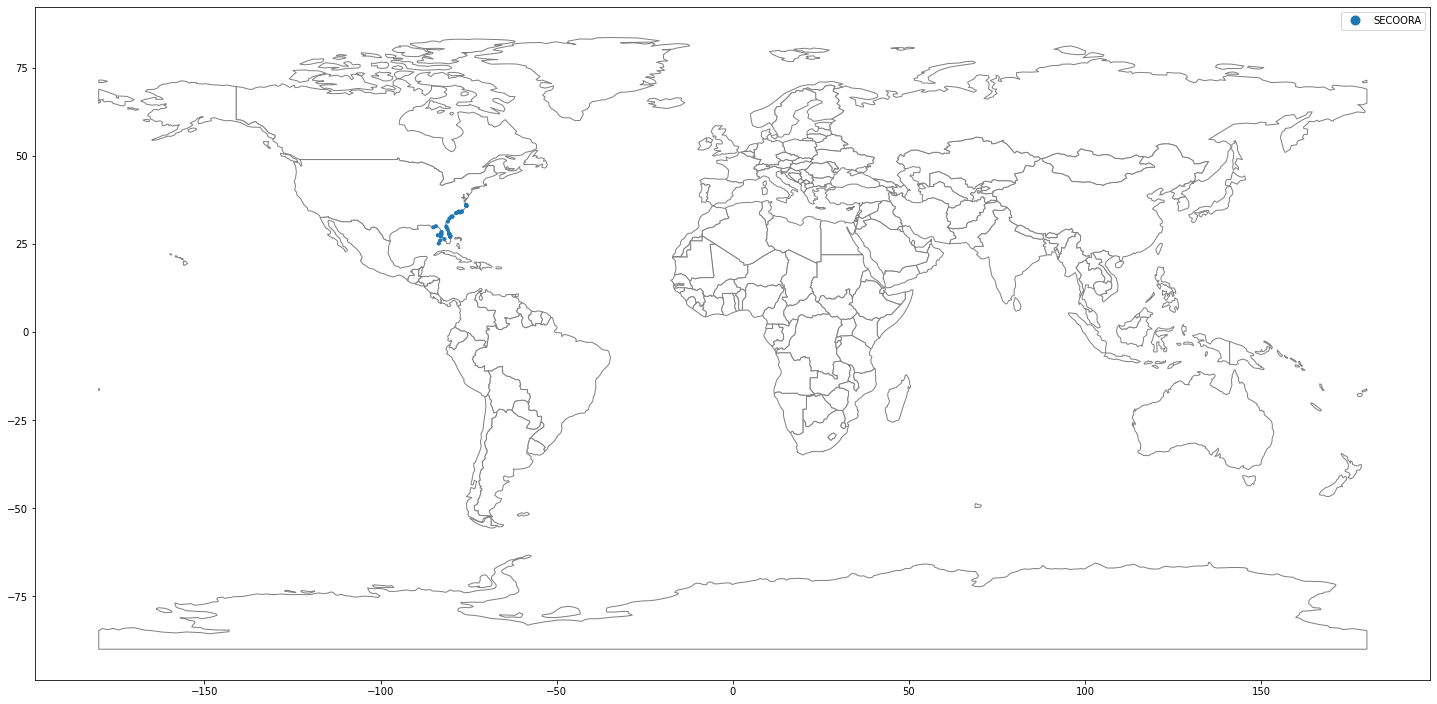

In [23]:
import geopandas
import matplotlib.pyplot as plt

df['Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)'] = \
    df['Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)'].astype(str)

df.rename(columns=
{'Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].':
     'Variable Names',
 'Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)': 'Station Deployment',
 'Longitude (dec deg)': 'Longitude',
 'Latitude (dec deg)': 'Latitude'},
              inplace=True)

gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df['Longitude'], df['Latitude']))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='white', 
    edgecolor='grey', 
    figsize=(25,20),
    )

gdf.plot(ax=ax, 
         column='RA', 
         categorical=True, 
         markersize=10, 
         legend=True,
         k=11,
        )

plt.show()

In [25]:
gdf_final = gdf.set_crs(epsg=4326)

gdf_final.explore("RA")